# Менеджер датасета

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import Optional, Dict, Tuple
from pandas import DataFrame, Series

## Класс DatasetManager

In [2]:
class DatasetManager:
    """
    Менеджер датасета для задач регрессии: загрузка из CSV, анализ, предобработка и визуализация.

    Параметры:
        csv_path (str): Путь к CSV-файлу с данными.
        target_column (str): Название столбца с целевой переменной.
    Атрибуты:
        df (DataFrame): Полный исходный DataFrame.
        features (DataFrame): DataFrame с только признаками (без целевой переменной).
        target (Series): Серия с целевой переменной.
        scaled_features (DataFrame): DataFrame с масштабированными признаками.
        stats (Dict[str, DataFrame]): Словарь рассчитанных статистик.
    """

    def __init__(self, csv_path: str, target_column: str) -> None:
        self.csv_path: str = csv_path
        self.target_column: str = target_column
        self.df: Optional[DataFrame] = None
        self.features: Optional[DataFrame] = None
        self.target: Optional[Series] = None
        self.scaled_features: Optional[DataFrame] = None
        self.stats: Dict[str, DataFrame] = {}

        self._load_data()
        self._dataset_custom_preprocess()
        self._extract_features_target()

        if self.csv_path == 'housing_dataset.csv':
            self.remove_feature('Location')
            self.remove_feature('City')

    def _dataset_custom_preprocess(self):
        if self.csv_path == 'Student_Performance.csv':
            self.df["Extracurricular Activities"] = self.df["Extracurricular Activities"].map({"Yes":1 , "No":0})
        else:
            cols_to_check = [col for col in self.df.columns if col != "No. of Bedrooms"]
            mask_no_nines = (self.df[cols_to_check] != 9).all(axis=1)
            self.df = self.df[mask_no_nines].reset_index(drop=True)

    def _load_data(self) -> None:
        """
        Загружает данные из CSV-файла в self.df.

        Выбрасывает:
            FileNotFoundError: если файл по пути csv_path не найден.
            pd.errors.EmptyDataError: если CSV пустой или неверный формат.
        """
        try:
            self.df = pd.read_csv(self.csv_path)
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Файл не найден по пути: {self.csv_path}") from e
        except pd.errors.EmptyDataError as e:
            raise pd.errors.EmptyDataError(
                f"Пустой или некорректный CSV: {self.csv_path}"
            ) from e

        print(
            f"Данные загружены: {self.df.shape[0]} строк, {self.df.shape[1]} столбцов"
        )

    def _extract_features_target(self) -> None:
        """
        Разделяет DataFrame на признаки и целевую переменную.

        После выполнения:
            - self.features содержит все столбцы, кроме target_column.
            - self.target содержит Series с данными целевой переменной.
        Выбрасывает:
            ValueError: если target_column отсутствует в self.df.
        """
        if self.df is None:
            raise RuntimeError("Данные не загружены. Сначала вызовите _load_data().")

        if self.target_column not in self.df.columns:
            raise ValueError(
                f"Целевая переменная '{self.target_column}' не найдена в данных."
            )
        self.target = self.df[self.target_column].copy()
        self.features = self.df.drop(columns=[self.target_column]).copy()

    def compute_basic_statistics(self) -> Dict[str, DataFrame]:
        """
        Вычисляет базовые статистики по признакам и сохраняет их в self.stats.

        Сохраняются:
            - "describe": описательные статистики (mean, std, min, max, квартили) для каждого признака.
            - "correlation_matrix": матрица корреляций между признаками.
            - "target_distribution": описательные статистики целевой переменной.

        Возвращает:
            Dict[str, DataFrame]: Словарь со статистиками.
        Выбрасывает:
            RuntimeError: если признаки или целевая переменная не выделены.
        """
        if self.features is None or self.target is None:
            raise RuntimeError(
                "Признаки или целевая переменная не выделены. Вызовите _extract_features_target()."
            )

        desc_features = self.features.describe().T
        self.stats["describe"] = desc_features

        corr_features = self.features.corr()
        self.stats["correlation_matrix"] = corr_features

        desc_target = self.target.describe().to_frame(name="target_stats")
        self.stats["target_distribution"] = desc_target

        return self.stats

    def preprocess(
        self,
        drop_duplicates: bool = True,
        drop_outliers: bool = True,
        z_thresh: float = 3.0,
    ) -> None:
        """
        Предобработка данных:
            1. Удаление дубликатов (если drop_duplicates=True).
            2. Удаление выбросов по Z-оценке (если drop_outliers=True).
            3. Масштабирование признаков StandardScaler.

        Параметры:
            drop_duplicates (bool): Удалять ли полные дубликаты строк.
            drop_outliers (bool): Удалять ли выбросы по Z-оценке для каждого признака.
            z_thresh (float): Порог Z-оценки; строки, у которых |z_score| > z_thresh хотя бы по одному признаку, удаляются.

        После выполнения:
            - self.df обновляется без дубликатов и выбросов.
            - self.features и self.target обновляются согласно очищенному DataFrame.
            - self.scaled_features заполняется DataFrame с масштабированными признаками.
        Выбрасывает:
            RuntimeError: если self.df не инициализирован.
        """
        if self.df is None:
            raise RuntimeError("Данные не загружены. Сначала вызовите _load_data().")

        df_proc = self.df.copy()

        if drop_duplicates:
            before_dupes = df_proc.shape[0]
            df_proc = df_proc.drop_duplicates().reset_index(drop=True)
            after_dupes = df_proc.shape[0]
            print(f"Удалено дубликатов: {before_dupes - after_dupes}")

        if drop_outliers:
            df_no_target = df_proc.drop(columns=[self.target_column], errors="ignore")
            means = df_no_target.mean()
            stds = df_no_target.std(ddof=0)
            z_scores = (df_no_target - means) / stds
            mask = (z_scores.abs() <= z_thresh).all(axis=1)
            before_out = df_proc.shape[0]
            df_proc = df_proc[mask].reset_index(drop=True)
            after_out = df_proc.shape[0]
            print(f"Удалено выбросов: {before_out - after_out}")

        self.df = df_proc
        self.target = df_proc[self.target_column].copy()
        self.features = df_proc.drop(columns=[self.target_column]).copy()

        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(self.features)
        self.scaled_features = pd.DataFrame(
            scaled_array, columns=self.features.columns, index=self.features.index
        )

        print(
            "Предобработка завершена: дубликаты и выбросы удалены (если указано), признаки масштабированы."
        )

    def visualize_distributions(self, figsize: Tuple[int, int] = (12, 8)) -> None:
        """
        Строит гистограммы распределений каждого признака (до масштабирования).

        Параметры:
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.
        """
        if self.features is None:
            raise RuntimeError(
                "Признаки не выделены. Сначала вызовите _extract_features_target()."
            )

        n = len(self.features.columns)
        cols = 3
        rows = (n + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()

        for i, col in enumerate(self.features.columns):
            axes[i].hist(self.features[col], bins=15, edgecolor="black")
            axes[i].set_title(col)
        for j in range(n, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def visualize_correlation_heatmap(
        self, figsize: Tuple[int, int] = (18, 12)
    ) -> None:
        """
        Строит тепловую карту корреляций между признаками с помощью seaborn.

        Параметры:
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.
        Выбрасывает:
            RuntimeError: если self.features не инициализирован.
        """
        if self.features is None:
            raise RuntimeError(
                "Признаки не выделены. Вызовите _extract_features_target()."
            )

        plt.figure(figsize=figsize)
        sns.heatmap(
            self.features.corr(),
            annot=True,
            cmap="coolwarm",
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.7},
        )
        plt.title("Матрица корреляции признаков")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def split_data(self, test_size: float = 0.2, random_state: int = 42) -> None:
        """
        Разделяет данные на обучающую и тестовую выборки.

        Параметры:
            test_size (float): Доля тестовой выборки (по умолчанию 0.2).
            random_state (int): Seed для воспроизводимости (по умолчанию 42).
        Выбрасывает:
            RuntimeError: если self.scaled_features или self.target не инициализированы.
        """
        if self.scaled_features is None or self.target is None:
            raise RuntimeError("Данные не предобработаны. Вызовите preprocess().")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.scaled_features,
            self.target,
            test_size=test_size,
            random_state=random_state,
        )

        print(
            f"Данные разделены:\n"
            f"- Обучающая выборка: {self.X_train.shape[0]} образцов\n"
            f"- Тестовая выборка: {self.X_test.shape[0]} образцов"
        )

    def get_training_data(self) -> Tuple[DataFrame, Series]:
        """
        Возвращает обучающие данные (признаки и целевую переменную).

        Возвращает:
            Tuple[DataFrame, Series]: (X_train, y_train).
        Выбрасывает:
            RuntimeError: если split_data не был вызван.
        """
        if not hasattr(self, "X_train") or not hasattr(self, "y_train"):
            raise RuntimeError("Данные не разделены. Вызовите split_data().")
        return self.X_train, self.y_train

    def get_testing_data(self) -> Tuple[DataFrame, Series]:
        """
        Возвращает тестовые данные (признаки и целевую переменную).

        Возвращает:
            Tuple[DataFrame, Series]: (X_test, y_test).
        Выбрасывает:
            RuntimeError: если split_data не был вызван.
        """
        if not hasattr(self, "X_test") or not hasattr(self, "y_test"):
            raise RuntimeError("Данные не разделены. Вызовите split_data().")
        return self.X_test, self.y_test

    def remove_feature(self, feature_name: str) -> None:
        """
        Удаляет указанный признак из текущего набора данных.

        Параметры:
            feature_name (str): Название удаляемого признака.
        Исключения:
            ValueError: если feature_name не строка.
            KeyError: если признак отсутствует в self.features.
            RuntimeError: если self.features не инициализирован.
        """
        if self.features is None:
            raise RuntimeError(
                "Набор признаков пуст. Вызовите _extract_features_target()."
            )
        if not isinstance(feature_name, str):
            raise ValueError(
                f"Имя признака должно быть строкой, получено {type(feature_name).__name__}"
            )
        if feature_name not in self.features.columns:
            raise KeyError(
                f"Признак '{feature_name}' отсутствует в текущем наборе признаков."
            )

        self.features.drop(columns=[feature_name], inplace=True)
        if self.df is not None and feature_name in self.df.columns:
            self.df.drop(columns=[feature_name], inplace=True)
        if (
            self.scaled_features is not None
            and feature_name in self.scaled_features.columns
        ):
            self.scaled_features.drop(columns=[feature_name], inplace=True)

        print(f"Признак '{feature_name}' успешно удалён из набора данных.")


    def visualize_target_distribution(
        self, 
        figsize: Tuple[int, int] = (10, 6), 
        bins: int = 30, 
        kde: bool = True,
        log_scale: bool = False
    ) -> None:
        """
        Строит гистограмму распределения целевой переменной (цены дома).

        Параметры:
            figsize (Tuple[int, int]): Размер графика (ширина, высота).
            bins (int): Количество бинов для гистограммы.
            kde (bool): Отображать ли кривую оценки плотности.
            log_scale (bool): Использовать логарифмическую шкалу для оси Y.
        
        Выбрасывает:
            RuntimeError: Если целевая переменная не загружена.
        """
        if self.target is None:
            raise RuntimeError("Целевая переменная не загружена. Сначала вызовите _extract_features_target().")
        
        plt.figure(figsize=figsize)
        
        sns.histplot(
            self.target, 
            bins=bins, 
            kde=kde, 
            color='skyblue', 
            edgecolor='black', 
            linewidth=1.2,
            alpha=0.7
        )
        
        mean_val = self.target.mean()
        median_val = self.target.median()
        std_val = self.target.std()
        
        plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Медиана: {median_val:.2f}')
        plt.axvline(mean_val - std_val, color='purple', linestyle=':', linewidth=1.5, label=f'±1 STD')
        plt.axvline(mean_val + std_val, color='purple', linestyle=':', linewidth=1.5)
        
        if log_scale:
            plt.yscale('log')
            plt.ylabel('Частота (log scale)')
        else:
            plt.ylabel('Частота')
        
        plt.title(f'Распределение целевой переменной: {self.target_column}')
        plt.xlabel(self.target_column)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        stats_text = (
            f"Минимум: {self.target.min():.2f}\n"
            f"Максимум: {self.target.max():.2f}\n"
            f"Среднее: {mean_val:.2f}\n"
            f"Медиана: {median_val:.2f}\n"
            f"Станд. отклонение: {std_val:.2f}\n"
        )
        plt.annotate(
            stats_text, 
            xy=(0.98, 0.7), 
            xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
            horizontalalignment='right',
            fontsize=10
        )
        
        plt.tight_layout()
        plt.show()

## Загрузка датасета

In [3]:
manager = DatasetManager(csv_path="Student_Performance.csv", target_column="Performance Index")

Данные загружены: 10000 строк, 6 столбцов


## Описание признаков

In [4]:
stats = manager.compute_basic_statistics()
print("Описание признаков:")
stats["describe"]

Описание признаков:


,count,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Extracurricular Activities,10000.0,0.4948,0.499998,0.0,0.0,0.0,1.0,1.0
Sleep Hours,10000.0,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0


## Гистограмма распределения признаков

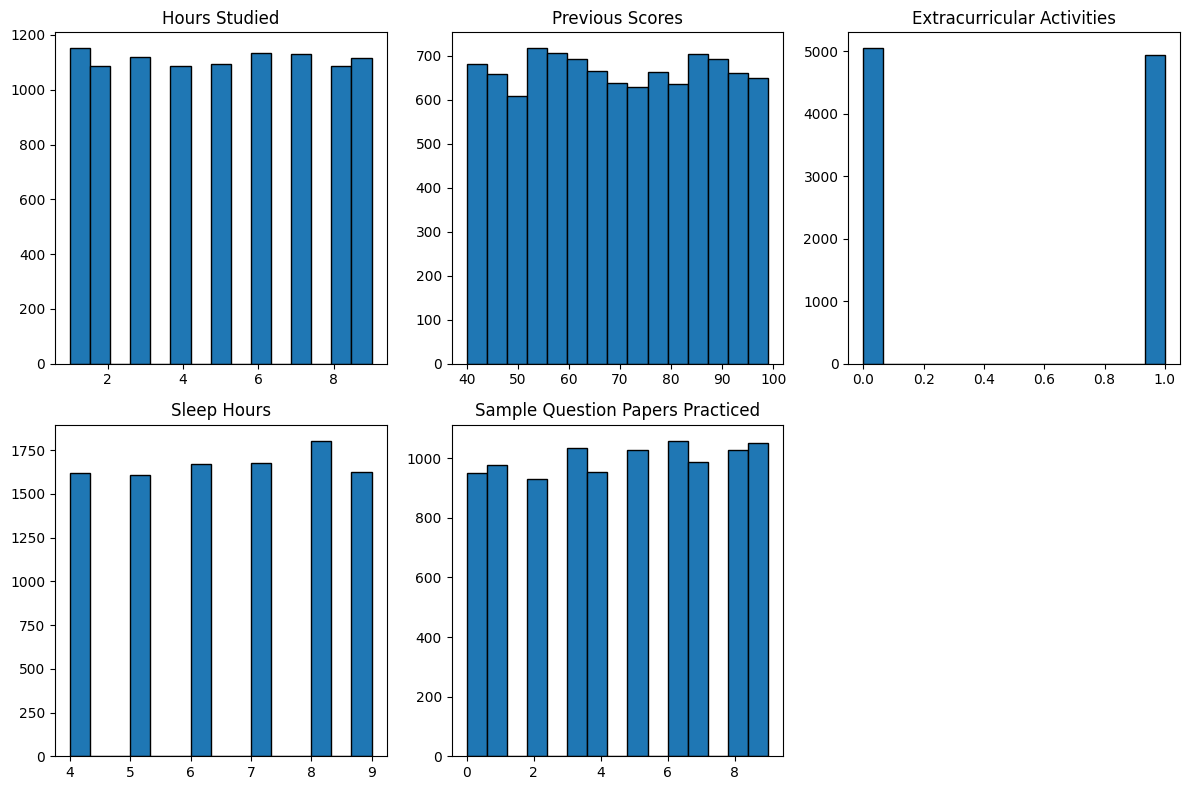

In [5]:
manager.visualize_distributions()

## Гистограмма распределения целевых меток

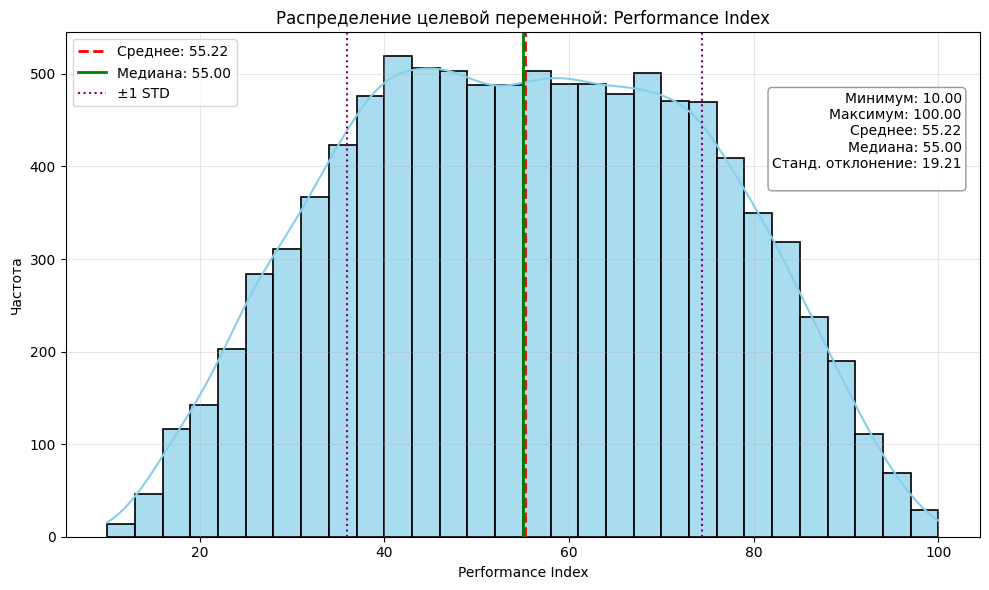

In [6]:
manager.visualize_target_distribution()

## Матрица корреляции между признаками

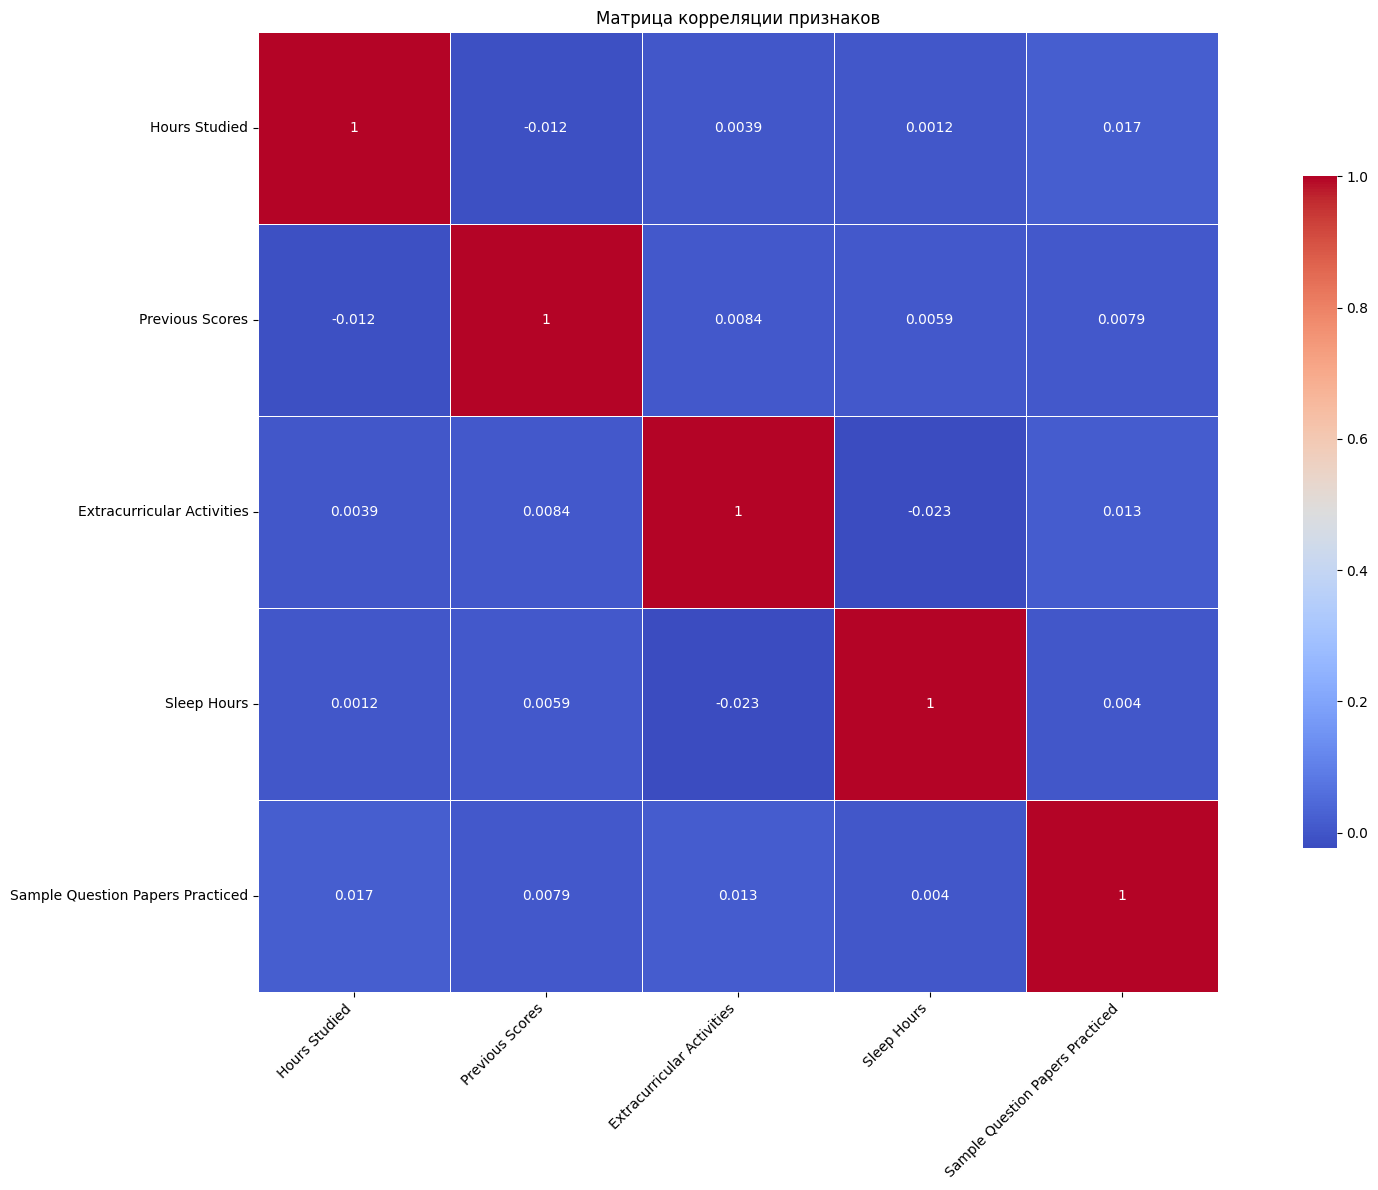

In [ ]:
manager.visualize_correlation_heatmap()

## Предобработка данных

In [8]:
manager.preprocess(drop_duplicates=True, drop_outliers=True, z_thresh=2.0)

Удалено дубликатов: 127
Удалено выбросов: 0
Предобработка завершена: дубликаты и выбросы удалены (если указано), признаки масштабированы.


## Разделение данных на тестовую и обучающие выборки

In [9]:
manager.split_data(test_size=0.2, random_state=42)

X_train, y_train = manager.get_training_data()
X_test, y_test = manager.get_testing_data()

Данные разделены:
- Обучающая выборка: 7898 образцов
- Тестовая выборка: 1975 образцов


# Линейная регрессия

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    explained_variance_score
)
from typing import List
import numpy as np

## Класс RegressionSklearn

In [11]:
class RegressionSklearn:
    """
    Класс для линейной регрессии (OLS) с использованием sklearn.

    Атрибуты:
        model (Optional[LinearRegression]): экземпляр обученной модели LinearRegression.
        feature_names (List[str]): список имён признаков, использованных при обучении.
        fitted (bool): флаг, указывающий, что модель обучена.

    Методы:
        fit(X_train, y_train) -> None:
            Обучает модель LinearRegression на тренировочных данных.
        evaluate(X_test, y_test) -> float:
            Вычисляет RMSE на тестовой выборке.
        plot_predicted_vs_actual(X, y, figsize=(8,6)) -> None:
            Строит scatter-диаграмму: предсказанные значения vs фактические.
    """

    def __init__(self) -> None:
        self.model: Optional[LinearRegression] = None
        self.feature_names: List[str] = []
        self.fitted: bool = False

    def fit(self, X_train: DataFrame, y_train: Series) -> None:
        """
        Обучает линейную регрессию (LinearRegression) на тренировочных данных.

        Параметры:
            X_train (DataFrame): DataFrame с признаками для обучения.
            y_train (Series): Series с целевой переменной для обучения.

        Исключения:
            ValueError: если X_train не DataFrame или y_train не Series,
                        либо их длины не совпадают.
        """
        if not isinstance(X_train, pd.DataFrame):
            raise ValueError("X_train должен быть pandas.DataFrame")
        if not isinstance(y_train, pd.Series):
            raise ValueError("y_train должен быть pandas.Series")
        if len(X_train) != len(y_train):
            raise ValueError("X_train и y_train должны быть одной длины")

        self.feature_names = list(X_train.columns)
        self.model = LinearRegression()
        self.model.fit(X_train, y_train)
        self.fitted = True

    def evaluate(self, X_test: DataFrame, y_test: Series) -> float:
        """
        Вычисляет RMSE (root mean squared error) на тестовой выборке.

        Параметры:
            X_test (DataFrame): DataFrame с признаками тестовой выборки.
            y_test (Series): Series с целевой переменной тестовой выборки.

        Возвращает:
            float: Значение RMSE на тестовых данных.

        Исключения:
            RuntimeError: если модель не обучена.
            ValueError: если X_test/y_test не тех типов или длины не совпадают.
        """
        if not self.fitted or self.model is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit().")
        if not isinstance(X_test, pd.DataFrame):
            raise ValueError("X_test должен быть pandas.DataFrame")
        if not isinstance(y_test, pd.Series):
            raise ValueError("y_test должен быть pandas.Series")
        if len(X_test) != len(y_test):
            raise ValueError("X_test и y_test должны быть одной длины")

        y_pred = self.model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test.values, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mdae = median_absolute_error(y_test, y_pred)

        return {
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "mdae": mdae,
            "r2": r2,
            "evs": evs,
        }

    def plot_predicted_vs_actual(
        self, X: DataFrame, y: Series, figsize: Tuple[int, int] = (8, 6)
    ) -> None:
        """
        Строит scatter-диаграмму: предсказанные значения vs фактические.

        Параметры:
            X (DataFrame): DataFrame признаков для предсказания.
            y (Series): Series фактических значений целевой переменной.
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.

        Исключения:
            RuntimeError: если модель не обучена.
            ValueError: если X/y не тех типов или длины не совпадают.
        """
        if not self.fitted or self.model is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit().")
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X должен быть pandas.DataFrame")
        if not isinstance(y, pd.Series):
            raise ValueError("y должен быть pandas.Series")
        if len(X) != len(y):
            raise ValueError("X и y должны быть одной длины")

        preds = self.model.predict(X)
        plt.figure(figsize=figsize)
        plt.scatter(y.values, preds, alpha=0.6, edgecolor="k")
        plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linewidth=2)
        plt.title("Предсказанные значения vs фактические")
        plt.xlabel("Фактические значения")
        plt.ylabel("Предсказанные значения")
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(
        self,
        figsize: Tuple[int, int] = (12, 8),
        importance_type: str = "coefficient",
        color: str = "skyblue",
    ) -> None:
        """
        Визуализирует важность признаков на основе коэффициентов линейной регрессии.

        Параметры:
            figsize (Tuple[int, int]): Размер графика (ширина, высота).
            importance_type (str): Тип важности:
                'coefficient' - исходные коэффициенты
                'absolute' - абсолютные значения коэффициентов
                'normalized' - нормализованные абсолютные значения (сумма=100%)
            color (str): Цвет столбцов диаграммы.
        """

        features = self.model.feature_names_in_
        coefs = self.model.coef_

        if importance_type == "coefficient":
            importance = coefs
            ylabel = "Коэффициент"
        elif importance_type == "absolute":
            importance = np.abs(coefs)
            ylabel = "Абсолютное значение коэффициента"
        elif importance_type == "normalized":
            importance = 100 * np.abs(coefs) / np.sum(np.abs(coefs))
            ylabel = "Относительная важность (%)"
        else:
            raise ValueError(
                f"Неизвестный тип важности: {importance_type}. "
                "Допустимые значения: 'coefficient', 'absolute', 'normalized'"
            )

        importance_df = pd.DataFrame({"feature": features, "importance": importance})

        importance_df = importance_df.sort_values(
            by="importance",
            ascending=True if importance_type == "coefficient" else False,
        )

        plt.figure(figsize=figsize)
        bars = plt.barh(
            importance_df["feature"],
            importance_df["importance"],
            color=color,
            edgecolor="black",
        )

        for bar in bars:
            width = bar.get_width()
            plt.annotate(
                f"{width:.4f}",
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=10,
            )

        plt.xlabel(ylabel)
        plt.title("Важность признаков в линейной регрессии")
        plt.grid(axis="x", alpha=0.3)
        plt.tight_layout()
        plt.show()

## Пример использования

In [12]:
reg = RegressionSklearn()
reg.fit(X_train, y_train)
metrics = reg.evaluate(X_test, y_test)

## График предсказанные значения vs фактические

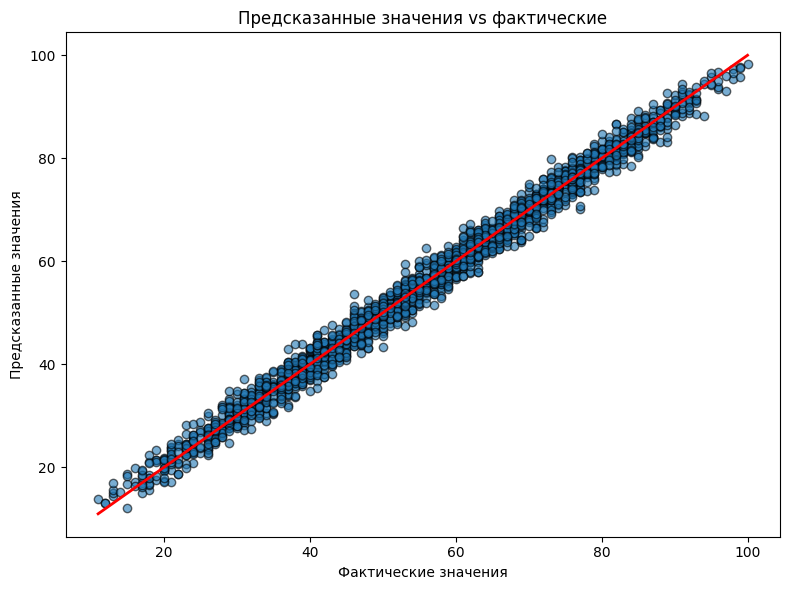

In [13]:
reg.plot_predicted_vs_actual(X_test, y_test)

## Значимость признаков (абсолютные значения)

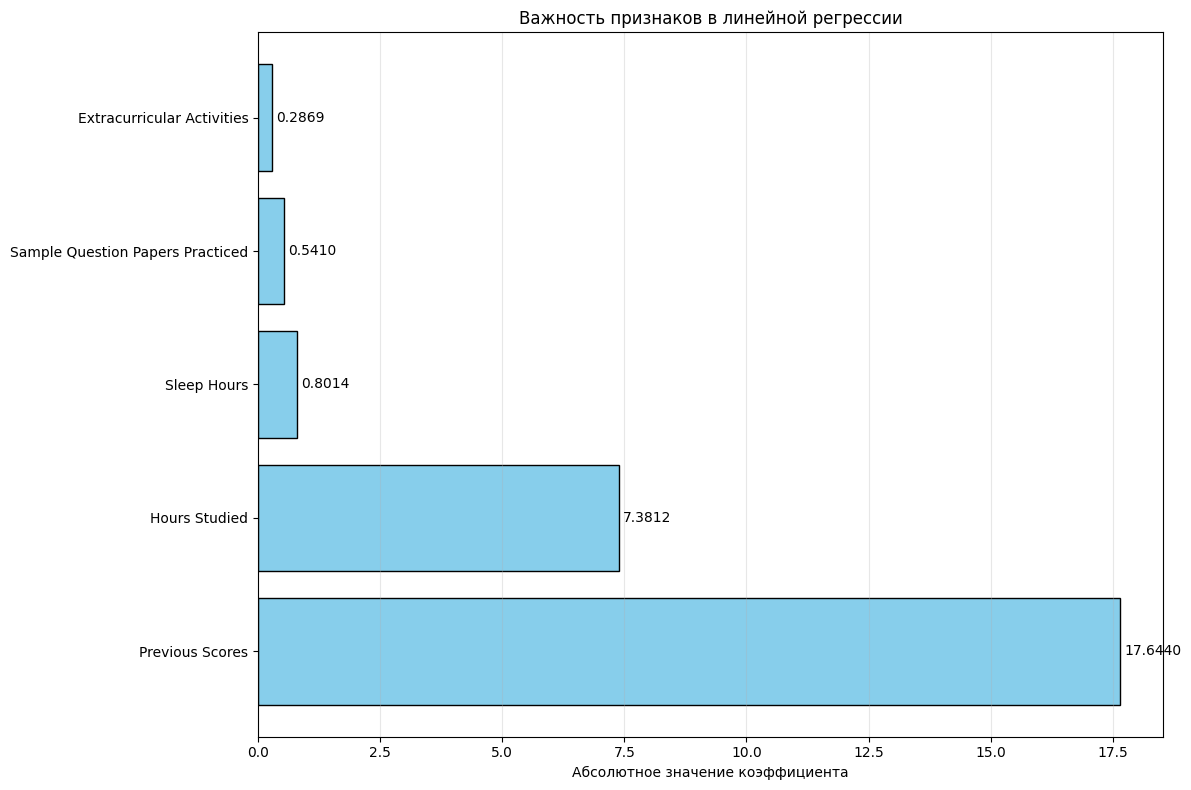

In [14]:
reg.plot_feature_importance(importance_type="absolute")

## Значимость признаков (нормализованные абсолютные значения)

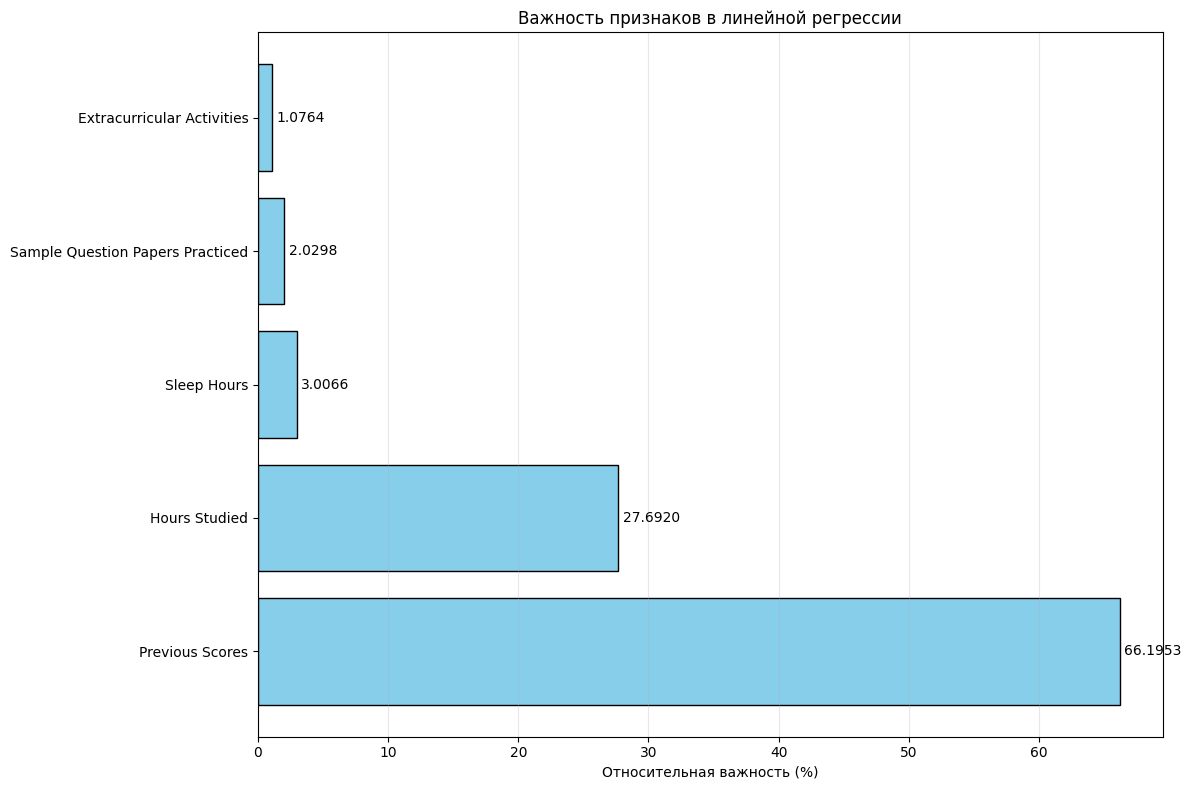

In [15]:
reg.plot_feature_importance(importance_type="normalized")

## Результаты оценки модели

In [16]:
print("Результаты оценки модели:")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.2f}")

Результаты оценки модели:
MSE: 4.31
RMSE: 2.08
MAE: 1.65
MDAE: 1.40
R2: 0.99
EVS: 0.99


## Собственная реализация линейной регрессии

In [17]:
from typing import Union

## Класс CustomLinearRegression

In [18]:
class CustomLinearRegression:
    """
    Кастомная реализация многомерной линейной регрессии с использованием стохастического градиентного спуска.

    Параметры:
        learning_rate (float): Скорость обучения (по умолчанию 0.01)
        epochs (int): Количество эпох обучения (по умолчанию 1000)
        batch_size (int): Размер батча для мини-пакетного обучения (по умолчанию 32)
        random_state (int): Seed для воспроизводимости (по умолчанию None)
        early_stopping (bool): Останавливать ли обучение при ухудшении ошибки (по умолчанию True)
        patience (int): Количество эпох для ранней остановки (по умолчанию 10)

    Атрибуты:
        weights (np.ndarray): Веса модели (включая смещение)
        feature_names (list): Имена признаков
        errors (list): История ошибок в процессе обучения
        best_weights (np.ndarray): Лучшие веса (при использовании ранней остановки)
    """

    def __init__(
        self,
        learning_rate: float = 0.01,
        epochs: int = 1000,
        batch_size: int = 32,
        random_state: Optional[int] = None,
        early_stopping: bool = True,
        patience: int = 10,
    ) -> None:
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.early_stopping = early_stopping
        self.patience = patience

        if random_state is not None:
            np.random.seed(random_state)

        self.weights = None
        self.feature_names = None
        self.errors = []
        self.best_weights = None
        self.best_error = float("inf")

    def _initialize_weights(self, n_features: int) -> None:
        """Инициализирует веса случайными малыми значениями"""
        self.weights = np.random.randn(n_features + 1) * 0.01

    def _add_bias(self, X: np.ndarray) -> np.ndarray:
        """Добавляет столбец единиц для смещения (bias)"""
        return np.c_[np.ones(X.shape[0]), X]

    def _calculate_loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """Вычисляет среднеквадратичную ошибку (MSE)"""
        predictions = X.dot(self.weights)
        return np.mean((predictions - y) ** 2)

    def _gradient_step(self, X_batch: np.ndarray, y_batch: np.ndarray) -> None:
        """Выполняет один шаг градиентного спуска"""
        predictions = X_batch.dot(self.weights)
        error = predictions - y_batch
        gradient = X_batch.T.dot(error) / len(X_batch)
        self.weights -= self.learning_rate * gradient

    def fit(
        self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]
    ) -> None:
        """
        Обучает модель линейной регрессии на предоставленных данных.

        Параметры:
            X (Union[np.ndarray, pd.DataFrame]): Матрица признаков
            y (Union[np.ndarray, pd.Series]): Вектор целевых значений

        Исключения:
            ValueError: Если размеры X и y не совпадают
        """
        if len(X) != len(y):
            raise ValueError("Размеры X и y должны совпадать")

        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = [f"feature_{i}" for i in range(X.shape[1])]

        X = np.array(X)
        y = np.array(y)

        self._initialize_weights(X.shape[1])
        X_with_bias = self._add_bias(X)

        no_improvement_count = 0
        self.errors = []
        self.best_weights = self.weights.copy()
        self.best_error = float("inf")

        for _ in range(self.epochs):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X_shuffled = X_with_bias[indices]
            y_shuffled = y[indices]

            for i in range(0, len(X), self.batch_size):
                end = min(i + self.batch_size, len(X))
                X_batch = X_shuffled[i:end]
                y_batch = y_shuffled[i:end]

                self._gradient_step(X_batch, y_batch)

            current_error = self._calculate_loss(X_with_bias, y)
            self.errors.append(current_error)

            if self.early_stopping:
                if current_error < self.best_error:
                    self.best_error = current_error
                    self.best_weights = self.weights.copy()
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count >= self.patience:
                    self.weights = self.best_weights
                    break

        if not self.early_stopping:
            self.best_weights = self.weights.copy()

    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """
        Предсказывает значения для новых данных.

        Параметры:
            X (Union[np.ndarray, pd.DataFrame]): Матрица признаков для предсказания

        Возвращает:
            np.ndarray: Предсказанные значения

        Исключения:
            RuntimeError: Если модель не обучена
        """
        if self.weights is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit()")

        X = np.array(X)
        X_with_bias = self._add_bias(X)
        return X_with_bias.dot(self.weights)

    def evaluate(
        self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]
    ) -> Dict[str, float]:
        """
        Оценивает модель на тестовых данных и возвращает комплекс метрик регрессии.

        Параметры:
            X (Union[np.ndarray, pd.DataFrame]): Матрица признаков
            y (Union[np.ndarray, pd.Series]): Вектор целевых значений

        Возвращает:
            Dict[str, float]: Словарь с метриками:
                - 'mse': Средняя квадратичная ошибка
                - 'rmse': Корень из средней квадратичной ошибки
                - 'mae': Средняя абсолютная ошибка
                - 'r2': Коэффициент детерминации (R²)
                - 'explained_variance': Объясненная дисперсия
        """
        y_pred = self.predict(X)
        y_true = np.array(y)

        mse = np.mean((y_true - y_pred) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))

        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_res = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - (ss_res / ss_total)

        explained_variance = 1 - (np.var(y_true - y_pred) / np.var(y_true))

        return {
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "explained_variance": explained_variance,
        }

    def get_feature_importance(self) -> Dict[str, float]:
        """
        Возвращает важность признаков на основе абсолютных значений весов.

        Возвращает:
            Dict[str, float]: Словарь {имя_признака: важность}

        Исключения:
            RuntimeError: Если модель не обучена
        """
        if self.weights is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit()")

        feature_weights = self.weights[1:]

        abs_weights = np.abs(feature_weights)
        normalized_importance = 100 * abs_weights / np.sum(abs_weights)

        return dict(zip(self.feature_names, normalized_importance))

    def plot_learning_curve(self, figsize: Tuple[int, int] = (10, 6)) -> None:
        """
        Визуализирует кривую обучения (ошибка vs эпохи).

        Исключения:
            RuntimeError: Если модель не обучена
        """
        if not self.errors:
            raise RuntimeError("История ошибок недоступна. Сначала обучите модель")

        plt.figure(figsize=figsize)
        plt.plot(self.errors)
        plt.title("Кривая обучения")
        plt.xlabel("Эпоха")
        plt.ylabel("MSE")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_predictions_vs_actual(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        figsize: Tuple[int, int] = (8, 6),
    ) -> None:
        """
        Визуализирует предсказанные значения vs фактические значения.

        Исключения:
            RuntimeError: Если модель не обучена
        """
        y_pred = self.predict(X)
        y_true = np.array(y)

        plt.figure(figsize=figsize)
        plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")

        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], color="red", linewidth=2)

        plt.title("Предсказанные vs Фактические значения")
        plt.xlabel("Фактические значения")
        plt.ylabel("Предсказанные значения")
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_feature_importance(
        self, figsize: Tuple[int, int] = (10, 6), top_n: Optional[int] = None
    ) -> None:
        """
        Визуализирует важность признаков на основе абсолютных значений весов.

        Параметры:
            top_n (int): Количество топ-признаков для отображения (по умолчанию все)

        Исключения:
            RuntimeError: Если модель не обучена
        """
        importance = self.get_feature_importance()

        sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

        if top_n is not None:
            sorted_importance = sorted_importance[:top_n]

        features, importances = zip(*sorted_importance)

        plt.figure(figsize=figsize)
        plt.barh(features, importances, color="skyblue")
        plt.title("Важность признаков")
        plt.xlabel("Важность (%)")
        plt.grid(axis="x", alpha=0.3)
        plt.tight_layout()
        plt.show()

    def get_coefficients(self) -> Dict[str, float]:
        """
        Возвращает коэффициенты модели для каждого признака.

        Возвращает:
            Dict[str, float]: Словарь {имя_признака: коэффициент}

        Исключения:
            RuntimeError: Если модель не обучена
        """
        if self.weights is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit()")

        feature_weights = self.weights[1:]
        return dict(zip(self.feature_names, feature_weights))

## Пример использования

In [19]:
custom_model = CustomLinearRegression(
    learning_rate=0.01,
    epochs=1000,
    batch_size=32,
    random_state=42,
    early_stopping=True,
    patience=20,
)
custom_model.fit(X_train, y_train)

test_metrics = custom_model.evaluate(X_test, y_test)

## Результаты оценки модели

In [20]:
print("Метрики на тестовой выборке:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Метрики на тестовой выборке:
mse: 4.3069
rmse: 2.0753
mae: 1.6471
r2: 0.9884
explained_variance: 0.9884


## Кривая обучения модели

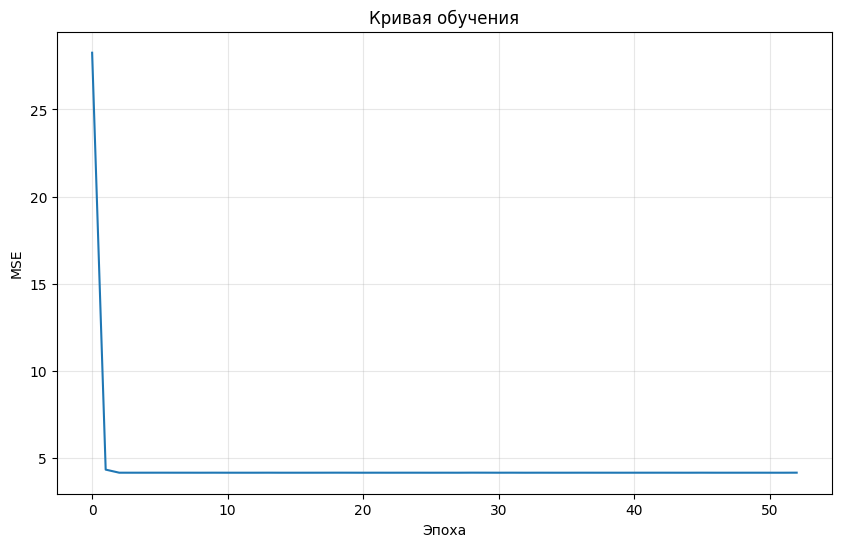

In [21]:
custom_model.plot_learning_curve()

## График предсказанные значения vs фактические

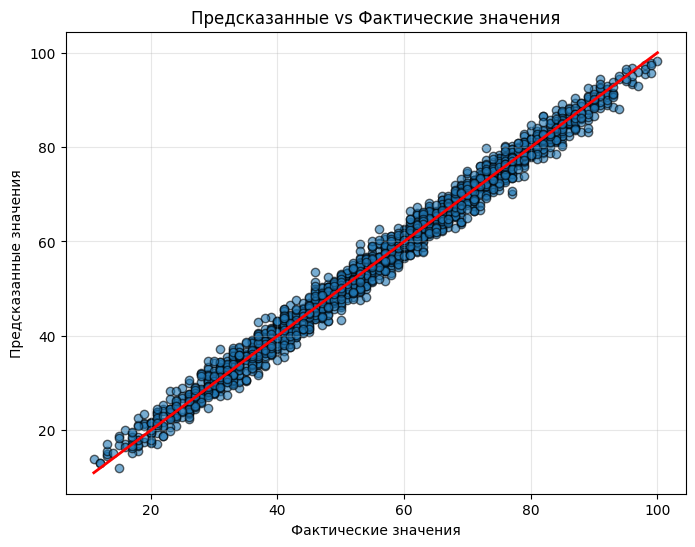

In [22]:
custom_model.plot_predictions_vs_actual(X_test, y_test)

## Значимость признаков (нормализованные абсолютные значения)

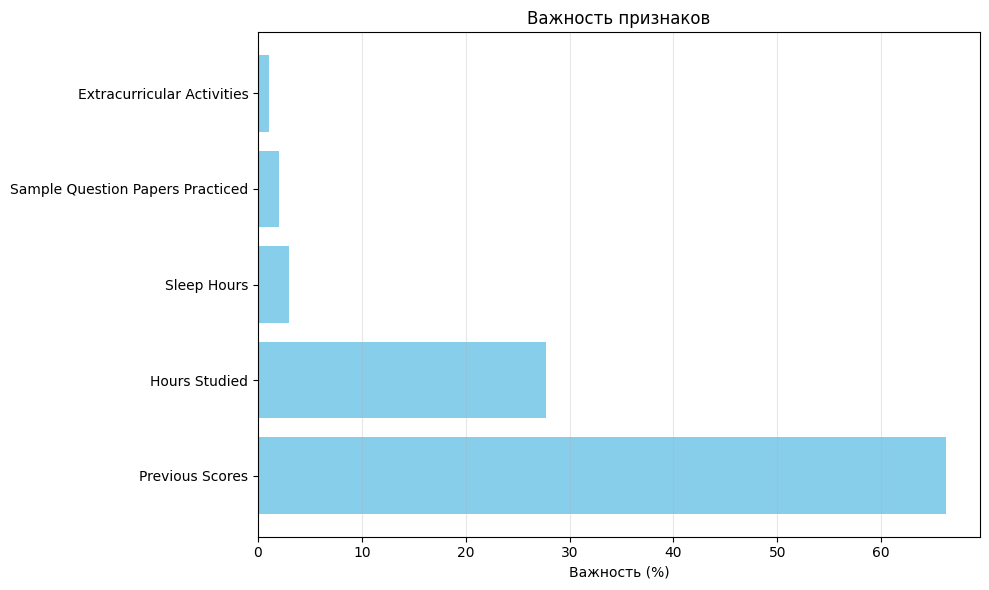

In [23]:
custom_model.plot_feature_importance(top_n=10)

## Коэффициенты модели

In [24]:
coefficients = custom_model.get_coefficients()
print("Коэффициенты модели:")
for feature, coef in coefficients.items():
    print(f"{feature}: {coef:.4f}")

Коэффициенты модели:
Hours Studied: 7.3776
Previous Scores: 17.6295
Extracurricular Activities: 0.2908
Sleep Hours: 0.8034
Sample Question Papers Practiced: 0.5302


# Регрессия Лассо

In [25]:
from sklearn.linear_model import Lasso

## Класс LassoRegressionSklearn

In [26]:
class LassoRegressionSklearn:
    def __init__(self) -> None:
        """
        Инициализирует пустые атрибуты модели.
        """
        self.model: Optional[Lasso] = None
        self.feature_names: List[str] = []
        self.fitted: bool = False

    def fit(
        self,
        X_train: DataFrame,
        y_train: Series,
        alpha: float = 1.0,
        max_iter: int = 1000,
        random_state: Optional[int] = None,
    ) -> None:
        """
        Обучает модель Lasso (sklearn.linear_model.Lasso) на тренировочных данных.

        Параметры:
            X_train (DataFrame): DataFrame с признаками для обучения.
            y_train (Series): Series с целевой переменной для обучения.
            alpha (float): Коэффициент регуляризации L1 (по умолчанию 1.0).
            max_iter (int): Максимальное число итераций для оптимизации (по умолчанию 1000).
            random_state (Optional[int]): Сид для воспроизводимости (по умолчанию None).

        Исключения:
            ValueError: если X_train не pandas.DataFrame или y_train не pandas.Series,
                        либо их длины не совпадают.
        """
        if not isinstance(X_train, pd.DataFrame):
            raise ValueError("X_train должен быть pandas.DataFrame")
        if not isinstance(y_train, pd.Series):
            raise ValueError("y_train должен быть pandas.Series")
        if len(X_train) != len(y_train):
            raise ValueError("X_train и y_train должны быть одной длины")

        self.feature_names = list(X_train.columns)
        self.model = Lasso(alpha=alpha, max_iter=max_iter, random_state=random_state)
        self.model.fit(X_train, y_train)
        self.fitted = True

    def evaluate(self, X_test: DataFrame, y_test: Series) -> Dict[str, float]:
        """
        Вычисляет основные метрики качества на тестовой выборке:
            - MSE (mean squared error)
            - RMSE (root mean squared error)
            - MAE (mean absolute error)
            - MdAE (median absolute error)
            - R2 score (коэффициент детерминации)
            - EVS (explained variance score)

        Параметры:
            X_test (DataFrame): DataFrame с признаками тестовой выборки.
            y_test (Series): Series с целевой переменной тестовой выборки.

        Возвращает:
            Dict[str, float]: Словарь с ключами ["mse", "rmse", "mae", "mdae", "r2", "evs"].

        Исключения:
            RuntimeError: если модель не обучена.
            ValueError: если X_test/y_test не тех типов или длины не совпадают.
        """
        if not self.fitted or self.model is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit().")
        if not isinstance(X_test, pd.DataFrame):
            raise ValueError("X_test должен быть pandas.DataFrame")
        if not isinstance(y_test, pd.Series):
            raise ValueError("y_test должен быть pandas.Series")
        if len(X_test) != len(y_test):
            raise ValueError("X_test и y_test должны быть одной длины")

        y_pred = self.model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mdae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)

        return {
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "mdae": mdae,
            "r2": r2,
            "evs": evs,
        }

    def plot_predicted_vs_actual(
        self, X: DataFrame, y: Series, figsize: Tuple[int, int] = (8, 6)
    ) -> None:
        """
        Строит scatter-диаграмму: предсказанные значения vs фактические.

        Параметры:
            X (DataFrame): DataFrame с признаками для предсказания.
            y (Series): Series с фактическими значениями целевой переменной.
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.

        Исключения:
            RuntimeError: если модель не обучена.
            ValueError: если X/y не тех типов или длины не совпадают.
        """
        if not self.fitted or self.model is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit().")
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X должен быть pandas.DataFrame")
        if not isinstance(y, pd.Series):
            raise ValueError("y должен быть pandas.Series")
        if len(X) != len(y):
            raise ValueError("X и y должны быть одной длины")

        y_pred = self.model.predict(X)
        plt.figure(figsize=figsize)
        plt.scatter(y.values, y_pred, alpha=0.6, edgecolor="k")
        plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linewidth=2)
        plt.title("Предсказанные значения vs фактические (Lasso)")
        plt.xlabel("Фактические значения")
        plt.ylabel("Предсказанные значения")
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(
        self,
        figsize: Tuple[int, int] = (12, 8),
        importance_type: str = "coefficient",
        color: str = "skyblue",
    ) -> None:
        """
        Визуализирует важность признаков на основе коэффициентов Lasso-модели.

        Параметры:
            figsize (Tuple[int, int]): Размер графика (ширина, высота).
            importance_type (str): Тип важности:
                - 'coefficient'  : исходные коэффициенты (с учётом знака)
                - 'absolute'     : абсолютные значения коэффициентов
                - 'normalized'   : относительные абсолютные (в сумме = 100%)
            color (str): Цвет столбцов диаграммы.

        Исключения:
            RuntimeError: если модель не обучена.
            ValueError: если importance_type задан неверно.
        """
        if not self.fitted or self.model is None:
            raise RuntimeError("Модель не обучена. Сначала вызовите fit().")

        coefs = self.model.coef_
        features = np.array(self.feature_names)

        if importance_type == "coefficient":
            importance = coefs
            ylabel = "Коэффициент"
        elif importance_type == "absolute":
            importance = np.abs(coefs)
            ylabel = "Абсолютное значение коэффициента"
        elif importance_type == "normalized":
            abs_vals = np.abs(coefs)
            if abs_vals.sum() == 0:
                importance = abs_vals
            else:
                importance = 100 * abs_vals / abs_vals.sum()
            ylabel = "Относительная важность (%)"
        else:
            raise ValueError(
                f"Неизвестный тип важности: {importance_type}. "
                "Допустимые: 'coefficient', 'absolute', 'normalized'"
            )

        importance_df = pd.DataFrame({"feature": features, "importance": importance})

        ascending = True if importance_type == "coefficient" else False
        importance_df = importance_df.sort_values(by="importance", ascending=ascending)

        plt.figure(figsize=figsize)
        bars = plt.barh(
            importance_df["feature"],
            importance_df["importance"],
            color=color,
            edgecolor="black",
        )

        for bar in bars:
            width = bar.get_width()
            plt.annotate(
                f"{width:.4f}",
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=10,
            )

        plt.xlabel(ylabel)
        plt.title("Важность признаков в Lasso-регрессии")
        plt.grid(axis="x", alpha=0.3)
        plt.tight_layout()
        plt.show()

## Пример использования

Результаты оценки Lasso-модели:
MSE: 4.4102
RMSE: 2.1001
MAE: 1.6666
MDAE: 1.4402
R2: 0.9881
EVS: 0.9882


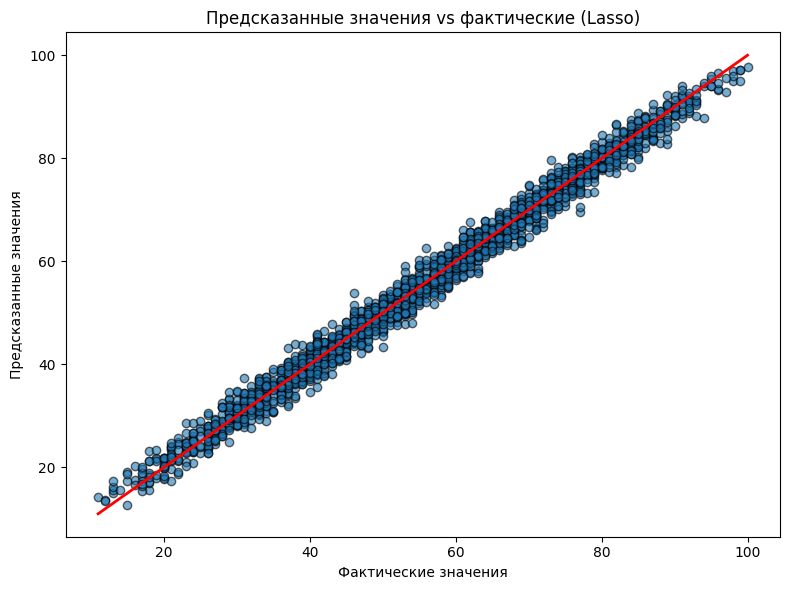

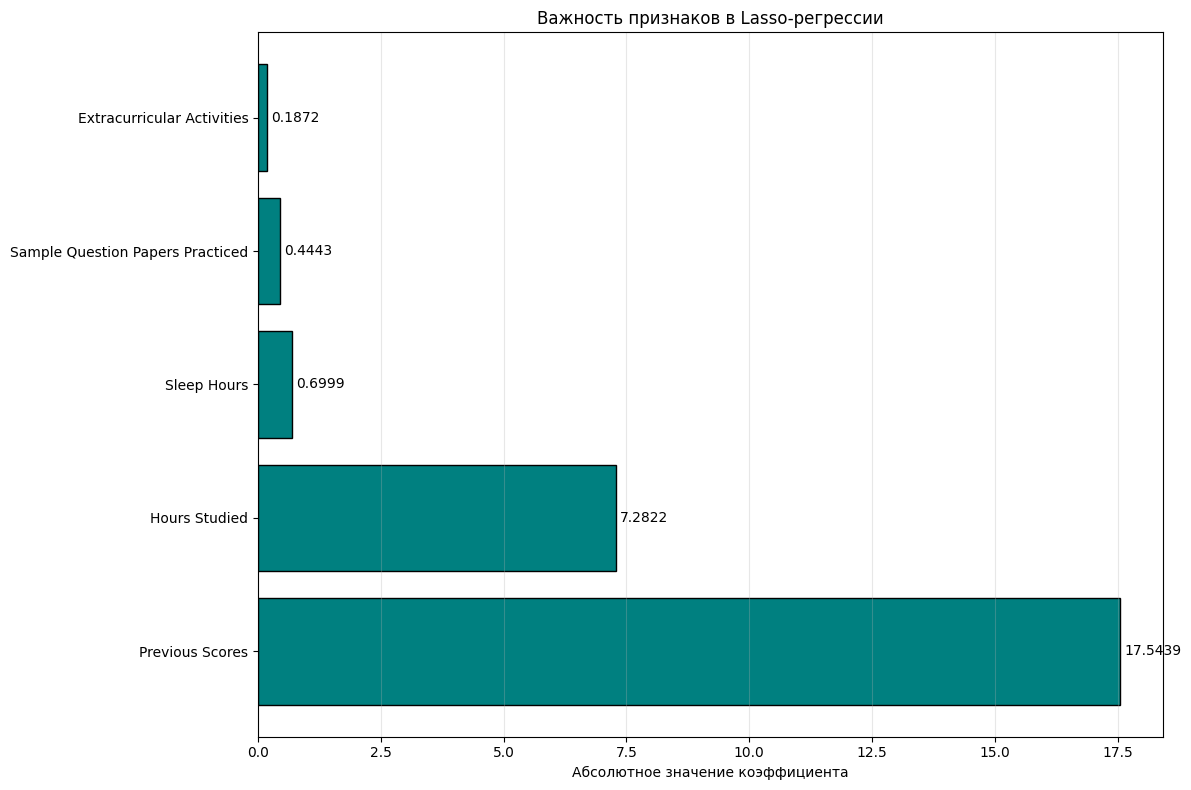

In [37]:
lasso_reg = LassoRegressionSklearn()
lasso_reg.fit(X_train, y_train, alpha=0.1, max_iter=1000, random_state=42)

metrics = lasso_reg.evaluate(X_test, y_test)
print("Результаты оценки Lasso-модели:")
for name, value in metrics.items():
    print(f"{name.upper()}: {value:.4f}")

lasso_reg.plot_predicted_vs_actual(X_test, y_test)

lasso_reg.plot_feature_importance(importance_type="absolute", color="teal")